# References

[Course Webpage](https://sites.google.com/view/berkeley-cs294-158-sp20/home)

[1] Pathak, Deepak, et al. "Context encoders: Feature learning by inpainting." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.

[2] Gidaris, Spyros, Praveer Singh, and Nikos Komodakis. "Unsupervised representation learning by predicting image rotations." arXiv preprint arXiv:1803.07728 (2018).

[3] Chen, Ting, et al. "A simple framework for contrastive learning of visual representations." arXiv preprint arXiv:2002.05709 (2020).

[4] Noroozi, Mehdi, and Paolo Favaro. "Unsupervised learning of visual representations by solving jigsaw puzzles." European Conference on Computer Vision. Springer, Cham, 2016.

[5] Wang, Xiaolong, Allan Jabri, and Alexei A. Efros. "Learning correspondence from the cycle-consistency of time." Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2019.

[6] Oord, Aaron van den, Yazhe Li, and Oriol Vinyals. "Representation learning with contrastive predictive coding." arXiv preprint arXiv:1807.03748 (2018).

[7] Hénaff, Olivier J., et al. "Data-efficient image recognition with contrastive predictive coding." arXiv preprint arXiv:1905.09272 (2019).

[8] Tian, Yonglong, Dilip Krishnan, and Phillip Isola. "Contrastive multiview coding." arXiv preprint arXiv:1906.05849 (2019).

[9] He, Kaiming, et al. "Momentum contrast for unsupervised visual representation learning." arXiv preprint arXiv:1911.05722 (2019).

[10] Doersch, Carl, Abhinav Gupta, and Alexei A. Efros. "Unsupervised visual representation learning by context prediction." Proceedings of the IEEE International Conference on Computer Vision. 2015.

[11] Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

# Getting Started
Go to **Runtime -> Change runtime type** and make sure **Hardward accelerator** is set to **GPU**

In [1]:
!if [ -d cs294-158-ssl ]; then rm -Rf cs294-158-ssl; fi
!git clone https://github.com/wilson1yan/cs294-158-ssl
!pip install cs294-158-ssl/

import os
os.chdir('cs294-158-ssl')

Cloning into 'cs294-158-ssl'...
remote: Enumerating objects: 611, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 611 (delta 115), reused 119 (delta 53), pack-reused 422
Receiving objects: 100% (611/611), 3.11 MiB | 16.03 MiB/s, done.
Resolving deltas: 100% (424/424), done.
Processing ./cs294-158-ssl
  Preparing metadata (setup.py) ... done
  Created wheel for deepul-helper: filename=deepul_helper-0.1.0-py3-none-any.whl size=25298 sha256=9b006362b1c4afb7c5c61224b119d2e572d5caca7a2d92a98bb6c45fb365f9c8
  Stored in directory: /root/.cache/pip/wheels/e3/df/97/281e32d717214451862e0e558746de423b9ef530b7376421e2
Successfully built deepul-helper


Run the cells below to download the necessary pretrained models. It should take a few minutes.

In [2]:
from google.colab import drive
import os
import zipfile
drive.mount('/content/drive')
data_folder="/content/drive/MyDrive/Master 2/Analyse d'image/TP4_/data.zip"
result_folder="/content/drive/MyDrive/Master 2/Analyse d'image/TP4_/results.zip"

if os.path.exists(data_folder):
    with zipfile.ZipFile(data_folder, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Fichier décompressé avec succès!")
else:
    print(f"Le fichier {data_folder} n'existe pas.")

if os.path.exists(result_folder):
    with zipfile.ZipFile(result_folder, 'r') as zip_ref:
        zip_ref.extractall('/content/cs294-158-ssl/')
    print("Fichier décompressé avec succès!")
else:
    print(f"Le fichier {result_folder} n'existe pas.")

Mounted at /content/drive
Fichier décompressé avec succès!
Fichier décompressé avec succès!


The models and demos shown were pre-trained. The code used for all the demos can be found in the github repo [here](https://github.com/wilson1yan/cs294-158-ssl). Follow the README to train models on CIFAR10 or ImageNet.

# Self-Supervised Learning Tasks
Self-supervised learning is a rapidly growing field, its success largely accelerated by growing compute and the vast amount of unlabeled data available for training. The hope is that by pretraining on specially designed self-supervised tasks, the models would be able to learn semantically meaningful representations to be used for downstream tasks. In the following demos, we will look at a few examples of these self-supervised tasks.

In [3]:
%matplotlib inline
from deepul_helper.demos import load_model_and_data, evaluate_classifier, display_nearest_neighbors, show_context_encoder_inpainting

In [4]:

def evaluate_accuracy(model, linear_classifier, train_loader, test_loader):
    train_acc1, train_acc5 = evaluate_classifier(model, linear_classifier, train_loader)
    test_acc1, test_acc5 = evaluate_classifier(model, linear_classifier, test_loader)

    print('Train Set')
    print(f'Top 1 Accuracy: {train_acc1}, Top 5 Accuracy: {train_acc5}\n')
    print('Test Set')
    print(f'Top 1 Accuracy: {test_acc1}, Top 5 Accuracy: {test_acc5}\n')

    return train_acc1, train_acc5,test_acc1, test_acc5

## Demo 1: Context Encoder [[1]](https://arxiv.org/abs/1604.07379)

The context encoder structures its self-supervised learning task by inpainting masked images. For example, the figure below shows different masking shapes, such as center masking, random block masking, and segmentation masking. Note that segmentation masking (c) is not purely self-supervised since we would need to train a image segmentation model which requires labels. However, the other two masking schemes (a) and (b) and purely self-supervised.

![](https://drive.google.com/uc?id=1fhzkULYTtyMGUUF2n9dlPayJSdcY5pRv)

More formally, the context encoder optimizes the following reconstruction loss:
$$\mathcal{L}_{rec} = \left\Vert \hat{M} \odot (x - F((1 - \hat{M})\odot x)) \right\Vert^2_2$$
where $\hat{M}$ is the masked region, $x$ is the image, and $F$ is the context encoder that tries to reconstruct the masked portion. In addition to the reconstruction loss, the paper introduces an adversarial loss that encourages more realistic inpaintings.
$$L_{adv} = \max_D \mathbb{E}_{x\in \chi} [\log(D(x)) + \log(1 - D(F((1-\hat{M})\odot x)))]$$
However, this demo does not use the adversarial portion of the loss.

### Example Code

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ContextEncoder(nn.Module):
    metrics = ['Loss']
    metrics_fmt = [':.4e']

    def __init__(self, dataset, n_classes):
        super().__init__()
        input_channels = 3

        self.latent_dim = 4000

        # Encodes the masked image
        self.encoder = nn.Sequential(
            # 128 x 128 Input
            nn.Conv2d(input_channels, 64, 4, stride=2, padding=1), # 64 x 64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, 4, stride=2, padding=1), # 32 x 32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # 16 x 16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), # 8 x 8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1), # 4 x 4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, self.latent_dim, 4) # 1 x 1
        )

        # Only reconstructs the masked part of the image and not the whole image
        self.decoder = nn.Sequential(
           nn.BatchNorm2d(self.latent_dim),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(self.latent_dim, 512, 4, stride=1, padding=0), # 4 x 4
           nn.BatchNorm2d(512),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1), # 8 x 8
           nn.BatchNorm2d(256),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # 16 x 16
           nn.BatchNorm2d(128),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), # 32 x 32
           nn.BatchNorm2d(64),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(64, input_channels, 4, stride=2, padding=1), # 64 x 64
           nn.Tanh()
        )

        self.dataset = dataset
        self.n_classes = n_classes

    def construct_classifier(self):
        classifier = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(self.latent_dim, affine=False),
            nn.Linear(self.latent_dim, self.n_classes)
        )
        return classifier

    def forward(self, images):
        # Extract a 64 x 64 center from 128 x 128 image
        images_center = images[:, :, 32:32+64, 32:32+64].clone()
        images_masked = images.clone()
        # Mask out a 64 x 64 center with slight overlap
        images_masked[:, 0, 32+4:32+64-4, 32+4:32+64-4] = 2 * 117.0/255.0 - 1.0
        images_masked[:, 1, 32+4:32+64-4, 32+4:32+64-4] = 2 * 104.0/255.0 - 1.0
        images_masked[:, 2, 32+4:32+64-4, 32+4:32+64-4] = 2 * 123.0/255.0 - 1.0

        z = self.encoder(images_masked)
        center_recon = self.decoder(z)

        return dict(Loss=F.mse_loss(center_recon, images_center)), torch.flatten(z, 1)

    def encode(self, images):
        images_masked = images
        images_masked[:, 0, 32+4:32+64-4, 32+4:32+64-4] = 2 * 117.0/255.0 - 1.0
        images_masked[:, 1, 32+4:32+64-4, 32+4:32+64-4] = 2 * 104.0/255.0 - 1.0
        images_masked[:, 2, 32+4:32+64-4, 32+4:32+64-4] = 2 * 123.0/255.0 - 1.0
        return self.encoder(images_masked)

    def reconstruct(self, images):
        images_center = images[:, :, 32:32+64, 32:32+64].clone()
        images_masked = images.clone()
        images_masked[:, 0, 32+4:32+64 - 4, 32+4:32+64-4] = 2 * 117.0/255.0 - 1.0
        images_masked[:, 1, 32+4:32+64 - 4, 32+4:32+64-4] = 2 * 104.0/255.0 - 1.0
        images_masked[:, 2, 32+4:32+64 - 4, 32+4:32+64-4] = 2 * 123.0/255.0 - 1.0

        z = self.encoder(images_masked)
        center_recon = self.decoder(z)

        images_recon = images_masked.clone()
        images_recon[:, :, 32:32+64, 32:32+64] = center_recon
        return images_masked, images_recon


### Inpainting Examples
For each pair of images, the left image is the masked input and the right the inpainted reconstruction.

In [ ]:
show_context_encoder_inpainting()

### Linear Classification
By design the model architecture is an encoder -> decoder module. We can use the bottleneck layer as our learned representation. Below, we show linear classification accuracy results on CIFAR10 using the learned representations.

In [6]:
model_context_encoder, linear_classifier_context_encoder, train_loader_context_encoder, test_loader_context_encoder = load_model_and_data('context_encoder')
train_acc1l_context_encoder, train_acc5l_context_encoder,test_acc1l_context_encoder, test_acc5l_context_encoder = evaluate_accuracy(model_context_encoder, linear_classifier_context_encoder, train_loader_context_encoder, test_loader_context_encoder)
model1_vals = [train_acc1l_context_encoder, train_acc5l_context_encoder,test_acc1l_context_encoder, test_acc5l_context_encoder]

100%|██████████| 170498071/170498071 [00:03<00:00, 51403302.61it/s]


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Set
Top 1 Accuracy: 53.236, Top 5 Accuracy: 94.094

Test Set
Top 1 Accuracy: 45.77, Top 5 Accuracy: 90.29



### Nearest Neighbors
Another way to evaluate our learned representation is to look at nearest neighbors to random encoded images in latent space.

In [7]:
display_nearest_neighbors('context_encoder', model_context_encoder, test_loader_context_encoder)

Image 1
Top 16 Nearest Neighbors (in latent space)
Image 2
Top 16 Nearest Neighbors (in latent space)
Image 3
Top 16 Nearest Neighbors (in latent space)
Image 4
Top 16 Nearest Neighbors (in latent space)


## Demo 2: Rotation Prediction [[2]](https://arxiv.org/abs/1803.07728)

In this paper, the authors show that accurately predicting the degrees of rotation in images is a self-supervised learning task that learns good representations for downstream tasks.

![](https://drive.google.com/uc?id=1eHXLH-N_6uMGRzdf1Wjnga26qlS5-FRv)

More specifically, the authors showed that training a common CNN architecture (AlexNet, ResNet) on the rotation task learns semantically interpretable convolutional masks similar to those learned in supervised learning.

### Example Code

In [8]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F


class RotationPrediction(nn.Module):
    metrics = ['Loss', 'Acc1']
    metrics_fmt = [':.4e', ':6.2f']

    def __init__(self, dataset, n_classes):
        super().__init__()
        if dataset == 'cifar10':
            self.model = NetworkInNetwork()
            self.latent_dim = 192 * 8 * 8
            self.feat_layer = 'conv2'
        elif 'imagenet' in dataset:
            self.model = AlexNet()
            self.latent_dim = 256 * 13 * 13
            self.feat_layer = 'conv5'
        else:
            raise Exception('Unsupported dataset:', dataset)
        self.dataset = dataset
        self.n_classes = n_classes

    def construct_classifier(self):
        if self.dataset == 'cifar10':
            classifier = nn.Sequential(
                Flatten(),
                nn.BatchNorm1d(self.latent_dim, affine=False),
                nn.Linear(self.latent_dim, self.n_classes)
            )
        elif 'imagenet' in self.dataset:
            classifier = nn.Sequential(
                nn.AdaptiveMaxPool2d((6, 6)),
                nn.BatchNorm2d(256, affine=False),
                Flatten(),
                nn.Linear(256 * 6 * 6, self.n_classes)
            )
        else:
            raise Exception('Unsupported dataset:', dataset)
        return classifier

    def forward(self, images):
        batch_size = images.shape[0]
        images, targets = self._preprocess(images)
        targets = targets.to(images.get_device())

        logits, zs = self.model(images, out_feat_keys=('classifier', self.feat_layer))
        loss = F.cross_entropy(logits, targets)

        pred = logits.argmax(dim=-1)
        correct = pred.eq(targets).float().sum()
        acc = correct / targets.shape[0] * 100.

        return dict(Loss=loss, Acc1=acc), zs[:batch_size]

    def encode(self, images):
        zs = self.model(images, out_feat_keys=(self.feat_layer,))
        return zs

    def _preprocess(self, images):
        batch_size = images.shape[0]
        images_90 = torch.flip(images.transpose(2, 3), (2,))
        images_180 = torch.flip(images, (2, 3))
        images_270 = torch.flip(images, (2,)).transpose(2, 3)
        images_batch = torch.cat((images, images_90, images_180, images_270), dim=0)
        targets = torch.arange(4).long().repeat(batch_size)
        targets = targets.view(batch_size, 4).transpose(0, 1)
        targets = targets.contiguous().view(-1)
        return images_batch, targets

### Linear Classification
We can use the feature maps in the later convolutional layers of the pretrained model as our learned representation for linear classification.

In [9]:
model_rotation, linear_classifier_rotation, train_loader_rotation, test_loader_rotation = load_model_and_data('rotation')

train_acc1_rotation, train_acc5_rotation,test_acc1_rotation, test_acc5_rotation = evaluate_accuracy(model_rotation, linear_classifier_rotation, train_loader_rotation, test_loader_rotation)
model2_vals = [train_acc1_rotation, train_acc5_rotation,test_acc1_rotation, test_acc5_rotation]

Files already downloaded and verified
Files already downloaded and verified
Train Set
Top 1 Accuracy: 79.502, Top 5 Accuracy: 99.096

Test Set
Top 1 Accuracy: 79.91, Top 5 Accuracy: 99.12



### Nearest Neighbors
Another way to evaluate our learned representation is to look at nearest neighbors to random encoded images in latent space.

In [10]:
display_nearest_neighbors('rotation', model_rotation, test_loader_rotation)

Image 1
Top 16 Nearest Neighbors (in latent space)
Image 2
Top 16 Nearest Neighbors (in latent space)
Image 3
Top 16 Nearest Neighbors (in latent space)
Image 4
Top 16 Nearest Neighbors (in latent space)


## Demo 3: SimCLR [[3]](https://arxiv.org/abs/2002.05709)

SimCLR is a contrastive learning framework to learn strong visual representations. An image $x$ is processed using data augmentation to produce two variants $x_i$ and $x_j$ which are both fed into encoder $f$ (a CNN) and projection head $g$ (a small MLP). The models optimize a contrastive loss to maximally align projected latents $z_i, z_j$. We consider $x_i, x_j$ as a positive pair, and any other $x_i, x_k$ pairs (i.e. different images in the same batch) are negative pairs. A visual diagram of the training procedure is shown below (from the paper).

![](https://drive.google.com/uc?id=1XW1uIkUTMSa0DZncivSYXzM5gA5FIhF6)

More formally, the loss between positive example $z_i, z_j$ is:
$$\ell_{i,j} = -\log{\frac{\exp(\text{sim}(z_i, z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i, z_k)/\tau)}}$$
where $\text{sim}(z_i, z_j) = z_i^Tz_j / (\left\Vert z_i \right\Vert \left\Vert z_j \right\Vert)$. The loss function can also be interpreted as a standard cross entropy loss to classify positive samples where logits are constructed using a given similarity function.

Note: A common idea in contrastive learning methods is that a larger batch means more negative samples. Therefore, these methods usually benefit the most from large-batch learning compared to other self-supervised learning tasks.

### Example Code

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from deepul_helper.resnet import resnet_v1
from deepul_helper.batch_norm import SyncBatchNorm, BatchNorm1d

# Some code adapted from https://github.com/sthalles/SimCLR
class SimCLR(nn.Module):
    metrics = ['Loss']
    metrics_fmt = [':.4e']

    def __init__(self, dataset, n_classes, dist=None):
        super().__init__()
        self.temperature = 0.5
        self.projection_dim = 128

        if dataset == 'cifar10':
            resnet = resnet_v1((3, 32, 32), 50, 1, cifar_stem=True)
            resnet = SyncBatchNorm.convert_sync_batchnorm(resnet)
            self.resnet = resnet
            self.latent_dim = 2048
        elif 'imagenet' in dataset:
            resnet = resnet_v1((3, 128, 128), 50, 1, cifar_stem=False)
            if dist is not None:
                resnet = nn.SyncBatchNorm.convert_sync_batchnorm(resnet)
            self.resnet = resnet
            self.latent_dim = 2048

        self.proj = nn.Sequential(
            nn.Linear(self.latent_dim, self.projection_dim, bias=False),
            BatchNorm1d(self.projection_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.projection_dim, self.projection_dim, bias=False),
            BatchNorm1d(self.projection_dim, center=False)
        )

        self.dataset = dataset
        self.n_classes = n_classes
        self.dist = dist

    def construct_classifier(self):
        return nn.Sequential(nn.Linear(self.latent_dim, self.n_classes))

    def forward(self, images):
        n = images[0].shape[0]
        xi, xj = images
        hi, hj = self.encode(xi), self.encode(xj) # (N, latent_dim)
        zi, zj = self.proj(hi), self.proj(hj) # (N, projection_dim)
        zi, zj = F.normalize(zi), F.normalize(zj)

        # Each training example has 2N - 2 negative samples
        # 2N total samples, but exclude the current and positive sample

        if self.dist is None:
            zis = [zi]
            zjs = [zj]
        else:
            zis = [torch.zeros_like(zi) for _ in range(self.dist.get_world_size())]
            zjs = [torch.zeros_like(zj) for _ in range(self.dist.get_world_size())]

            self.dist.all_gather(zis, zi)
            self.dist.all_gather(zjs, zj)

        z1 = torch.cat((zi, zj), dim=0) # (2N, projection_dim)
        z2 = torch.cat(zis + zjs, dim=0) # (2N * n_gpus, projection_dim)

        sim_matrix = torch.mm(z1, z2.t()) # (2N, 2N * n_gpus)
        sim_matrix = sim_matrix / self.temperature
        # Mask out same-sample terms
        n_gpus = 1 if self.dist is None else self.dist.get_world_size()
        rank = 0 if self.dist is None else self.dist.get_rank()
        sim_matrix[torch.arange(n), torch.arange(rank*n, (rank+1)*n)]  = -float('inf')
        sim_matrix[torch.arange(n, 2*n), torch.arange((n_gpus+rank)*n, (n_gpus+rank+1)*n)] = -float('inf')

        targets = torch.cat((torch.arange((n_gpus+rank)*n, (n_gpus+rank+1)*n),
                             torch.arange(rank*n, (rank+1)*n)), dim=0)
        targets = targets.to(sim_matrix.get_device()).long()

        loss = F.cross_entropy(sim_matrix, targets, reduction='sum')
        loss = loss / n
        return dict(Loss=loss), hi

    def encode(self, images):
        return self.resnet(images[0])

    def get_features(self, images):
        return self.resnet.get_features(images)


### Linear Classification
We can use the encoded vector $h_i$ as our latent representation.

In [12]:
model_simclr, linear_classifier_simclr, train_loader_simclr, test_loader_simclr = load_model_and_data('simclr')
train_acc1_simclr, train_acc5_simclr,test_acc1_simclr, test_acc5_simclr =evaluate_accuracy(model_simclr, linear_classifier_simclr, train_loader_simclr, test_loader_simclr)
model3_vals = [train_acc1_simclr, train_acc5_simclr,test_acc1_simclr, test_acc5_simclr]

Files already downloaded and verified
Files already downloaded and verified
Train Set
Top 1 Accuracy: 90.09, Top 5 Accuracy: 99.44

Test Set
Top 1 Accuracy: 92.84, Top 5 Accuracy: 99.86



### Nearest Neighbors
Another way to evaluate our learned representation is to look at nearest neighbors to random encoded images in latent space.

In [13]:
display_nearest_neighbors('simclr', model_simclr, test_loader_simclr)

Image 1
Top 16 Nearest Neighbors (in latent space)
Image 2
Top 16 Nearest Neighbors (in latent space)
Image 3
Top 16 Nearest Neighbors (in latent space)
Image 4
Top 16 Nearest Neighbors (in latent space)


/content/cs294-158-ssl/deepul_helper/demos.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


## Other Tasks
In addition to the above tasks, prior work has also investigated other self-superivsed tasks such as solving jigsaw puzzles [[4]](https://arxiv.org/abs/1603.09246), cycle-consistency [[5]](https://arxiv.org/abs/1903.07593), contrastive learning [[6]](https://arxiv.org/abs/1807.03748)[[7]](https://arxiv.org/abs/1905.09272)[[8]](https://arxiv.org/abs/1906.05849)[[9]](https://arxiv.org/abs/1911.05722), and patch prediction [[10]](https://arxiv.org/abs/1505.05192). See [here](https://github.com/jason718/awesome-self-supervised-learning) for a great resource on more self-supervised learning papers.

# Demo 4: Using Representations for Downstream Tasks

After pretraining a model on a self-supervised learning task, we can use it for other downstream tasks. In this demo, we use the pre-trained ResNet50 backbone from training SimCLR on a subset of ImageNet to learn a semantic segmentation model on Pascal VOC 2012. We use a simple U-Net [[11]](https://arxiv.org/abs/1505.04597) architecture with skip connections across feature maps between the SimCLR encoder and learned upsampling decoder. We do not fine-tune the SimCLR ResNet50 backbone, and only optimize the upsampling portion.

![](https://drive.google.com/uc?id=19dxxcwof0IA0jyv0VCl4rnZZf3ajA22s)

The training script can be found in `train_segmentation.py` [here](https://github.com/wilson1yan/cs294-158-ssl/blob/master/train_segmentation.py).

## Example Code

In [14]:
# Code adapted from https://github.com/qubvel/segmentation_models.pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from deepul_helper.resnet import NormReLU

class SegmentationModel(nn.Module):
    metrics = ['Loss']
    metrics_fmt = [':.4e']

    def __init__(self, n_classes):
        super().__init__()

        decoder_channels = (512, 256, 128, 64, 32)
        encoder_channels = (2048, 1024, 512, 256, 64) # Starting from head (resnet 50)

        # Construct decoder blocks
        in_channels = [encoder_channels[0]] + list(decoder_channels[:-1])
        skip_channels = list(encoder_channels[1:]) + [0]
        out_channels = decoder_channels
        blocks = [
            DecoderBlock(in_ch, skip_ch, out_ch)
            for in_ch, skip_ch, out_ch in zip(in_channels, skip_channels, out_channels)
        ]
        self.dec_blocks = nn.ModuleList(blocks)

        # Segmentation head for output prediction
        self.seg_head = nn.Conv2d(decoder_channels[-1], n_classes, kernel_size=3, padding=1)

    def forward(self, features, targets):
        features = features[1:] # remove first skip with same spatial resolution
        features = features[::-1] # reverse channels to start from head of encoder

        skips = features[1:]
        x = features[0]
        for i, decoder_block in enumerate(self.dec_blocks):
            skip = skips[i] if i < len(skips) else None
            x = decoder_block(x, skip)

        logits = self.seg_head(x)
        loss = F.cross_entropy(logits, targets)

        return dict(Loss=loss), logits


class DecoderBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            skip_channels,
            out_channels,
    ):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels + skip_channels, out_channels,
                      kernel_size=3, padding=1),
            NormReLU((out_channels, None, None)), # only care about channel dim for BN
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            NormReLU((out_channels, None, None))
        )

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

## Segmentation Results
Below, we show a random subset of segmentations from the trained model. Every set of 3 images consists of the original image, the labeled segmentation, and the predicted segmentation.

In [15]:
from deepul_helper.demos import show_segmentation
show_segmentation()

100%|██████████| 1999639040/1999639040 [00:50<00:00, 39666200.88it/s]


Extracting data/pascalvoc2012/VOCtrainval_11-May-2012.tar to data/pascalvoc2012
Using downloaded and verified file: data/pascalvoc2012/VOCtrainval_11-May-2012.tar
Extracting data/pascalvoc2012/VOCtrainval_11-May-2012.tar to data/pascalvoc2012


# Demo 5: Avoiding Trivial Representations in Self-Supervised Tasks

When designing a self-supervised learning task, it is important to make sure that no trivial solutions exists. In general, a learned solution is trivial if the model is able to successfully complete its task by taking advantage of low-level features. As a result, it doesn't learn a good representation so downstream performance is bad.

For example, in the jigsaw [[4]](https://arxiv.org/abs/1603.09246) task, a model can "cheat" by just looking at the boundary textures of the jigsaw pieces, or following and matching straight lines across different pieces. These issues can generally be fixed by ranndom cropping, shifting, and spacially jittering.

We look at two other less obvious aspects of images that may reduce performance.

## Chromatic Aberration

Chromatic aberration occurs when the different focal lengths of light results in the light not meeting all at the same point.
![from wikipedia](https://drive.google.com/uc?id=1PYGoQWnH0aAeiE_8t4ef5WDcq1UIQQ5t)

A example of very apparent chromatic aberration is shown below, where the green and magenta colors are clearly offset with each other:

![](https://drive.google.com/uc?id=1M1B6kV6ddBwyJse3FQT8_XBTeqs5s5WL)

Chromatic aberration generally becomes a problem in patch-based self-supervised learning tasks that design, such as solving jigsaw puzzles, or predicintg the correct location of a patch in an image In this case, the model can take advantage of the low-level chromatic aberration features to get a strong idea of where the patch is located without understanding the actual context.

Below is a quick demo of chromatic aberration in more realistic images, and possible fixes. Note that in general, chromatic aberration is fairly hard to spot with the naked eye, but deep learning models are still able to use it to their advantage.

In [16]:
from PIL import Image
import matplotlib.pyplot as plt
image = Image.open('sample_images/chrom_ab_demo.png')
plt.figure()
plt.axis('off')
plt.imshow(image)
plt.show()

Chromatic aberration is generally fixed through conversion to grayscale, or color dropping. Color dropping works by dropping 2 of the color channels and replacing them with random noise uniform or Gaussian noise.

In [17]:
import numpy as np

image_cpy = image.copy()
pixels = image_cpy.load()

arr = np.array(image_cpy)
std_R = np.std(arr[:, :, 0])
mean_G, mean_B = np.mean(arr[:, :, 1]), np.mean(arr[:, :, 2])

for i in range(image.size[0]):
  for j in range(image.size[1]):
    p = pixels[i, j] # (R, G, B, A)
    R, A = p[0], p[3]
    G = int(np.random.randn() * std_R + mean_G)
    B = int(np.random.randn() * std_R + mean_B)
    pixels[i, j] = (R, G, p[2], p[3])

plt.figure()
plt.title('Color Dropping')
plt.axis('off')
plt.imshow(image_cpy)
plt.show()

image_cpy2 = image.copy()
pixels2 = image_cpy2.load()

for i in range(image.size[0]):
  for j in range(image.size[1]):
    p = pixels[i, j]
    G = int(0.3 * p[0] + 0.59 * p[1] + 0.11 * p[2])
    pixels2[i, j] = (G, G, G, 255)

plt.figure()
plt.title('Grayscale')
plt.axis('off')
plt.imshow(image_cpy2)
plt.show()

## Color Intensity Histograms

In the SimCLR paper, the authors show that the histogram of color intensities of different patches within the same image have very similar histograms, which may degrade training by encouraging models to look at low-level (pixel intensity) features to solve self-supervised tasks that involve matching positive patches of the same image.

Below, we run a similar demo to what was demonstrated in the paper

In [18]:

from PIL import Image
import matplotlib.pyplot as plt

image = Image.open('sample_images/n01537544_19414.JPEG')
plt.figure()
plt.title('Original Image')
plt.axis('off')
plt.imshow(image)
plt.show()

In [19]:
import numpy as np
arr = np.array(image)
H, W, _ = arr.shape

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
  r = np.random.randint(0, H - 128)
  c = np.random.randint(0, W - 128)
  patch = arr[r:r+128, c:c+128]

  axs[i].set_title(f'Patch {i}')
  axs[i].hist(patch.reshape(-1), bins=50)
plt.show()

Now we apply color jittering to mitigate this effect

In [20]:
from torchvision import transforms

color_jitter = transforms.ColorJitter(0.3, 0.3, 0.3, 0.3)
jitter_img = color_jitter(image)

image = Image.open('sample_images/n01537544_19414.JPEG')
plt.figure()
plt.title('Color Jittered Image')
plt.axis('off')
plt.imshow(jitter_img)
plt.show()

In [21]:
arr = np.array(image)
H, W, _ = arr.shape

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
  r = np.random.randint(0, H - 128)
  c = np.random.randint(0, W - 128)
  patch = arr[r:r+128, c:c+128]

  axs[i].set_title(f'Patch {i}')
  axs[i].hist(patch.reshape(-1), bins=50)
plt.show()

#Comparaison des performances

In [30]:
import pandas as pd

labels = ['train accuracy top 1', 'train accuracy top 5','test accuracy top 1', "test accuracy top 5"]
x = range(len(labels))
df = pd.DataFrame({
    'Context encoder': model1_vals,
    'Rotation': model2_vals,
    'Simclr': model3_vals
})
df.index = labels
df

,Context encoder,Rotation,Simclr
train accuracy top 1,53.236,79.502,90.09
train accuracy top 5,94.094,99.096,99.44
test accuracy top 1,45.770,79.910,92.84
test accuracy top 5,90.290,99.120,99.86


In [27]:
path = "/content/drive/MyDrive/Master 2/Analyse d'image"

In [29]:
df = pd.read_csv(path+ '_df.csv')

In [ ]:
df.to_csv(path+ '_df.csv')

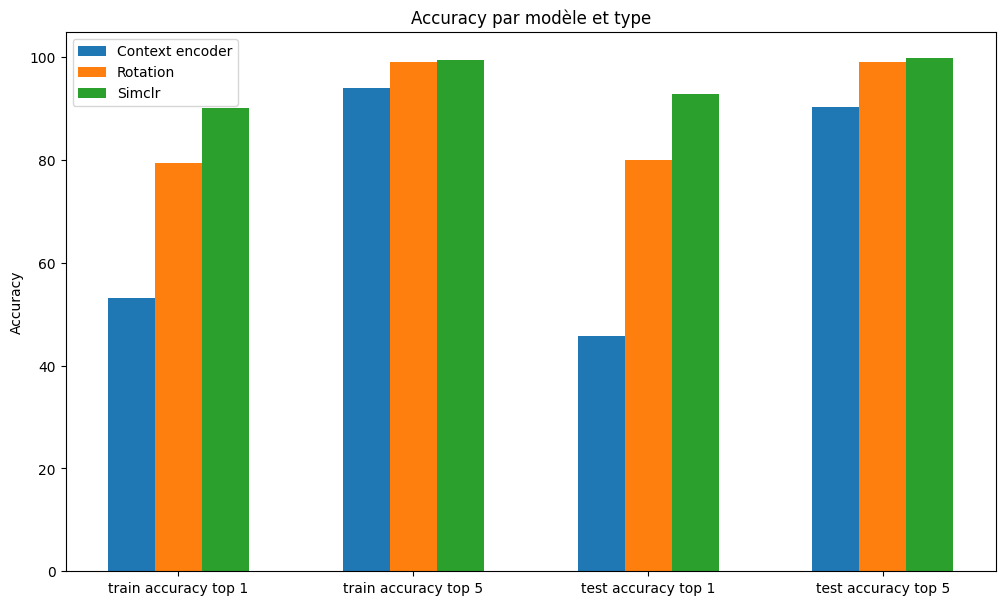

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

width = 0.2

plt.figure(figsize=(12, 7))

plt.bar([i - width for i in x], model1_vals, width, label='Context encoder')
plt.bar(x, model2_vals, width, label='Rotation')
plt.bar([i + width for i in x], model3_vals, width, label='Simclr')

plt.ylabel('Accuracy')
plt.title('Accuracy par modèle et type')
plt.xticks(x, labels)
plt.legend()
plt.show()

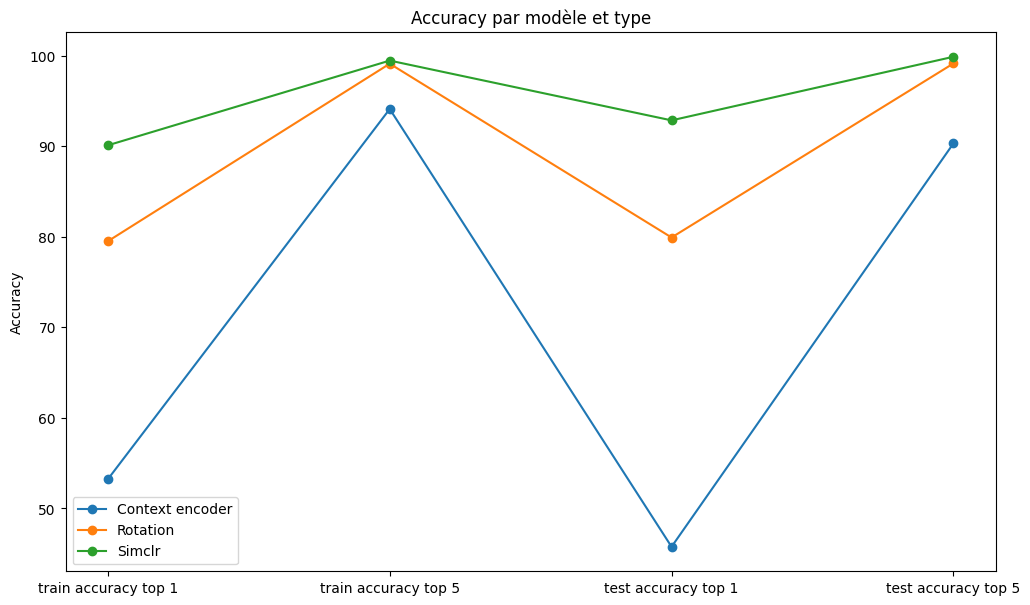

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 7))

plt.plot(x, model1_vals, marker='o', label='Context encoder', linestyle='-')
plt.plot(x, model2_vals, marker='o', label='Rotation', linestyle='-')
plt.plot(x, model3_vals, marker='o', label='Simclr', linestyle='-')

plt.fill_between(x, model1_vals, model2_vals, where=(np.array(model1_vals) > np.array(model2_vals)), facecolor='green', alpha=0.2)
plt.fill_between(x, model2_vals, model3_vals, where=(np.array(model2_vals) > np.array(model3_vals)), facecolor='blue', alpha=0.2)

plt.ylabel('Accuracy')
plt.title('Accuracy par modèle et type')
plt.xticks(x, labels)
plt.legend()

plt.show()


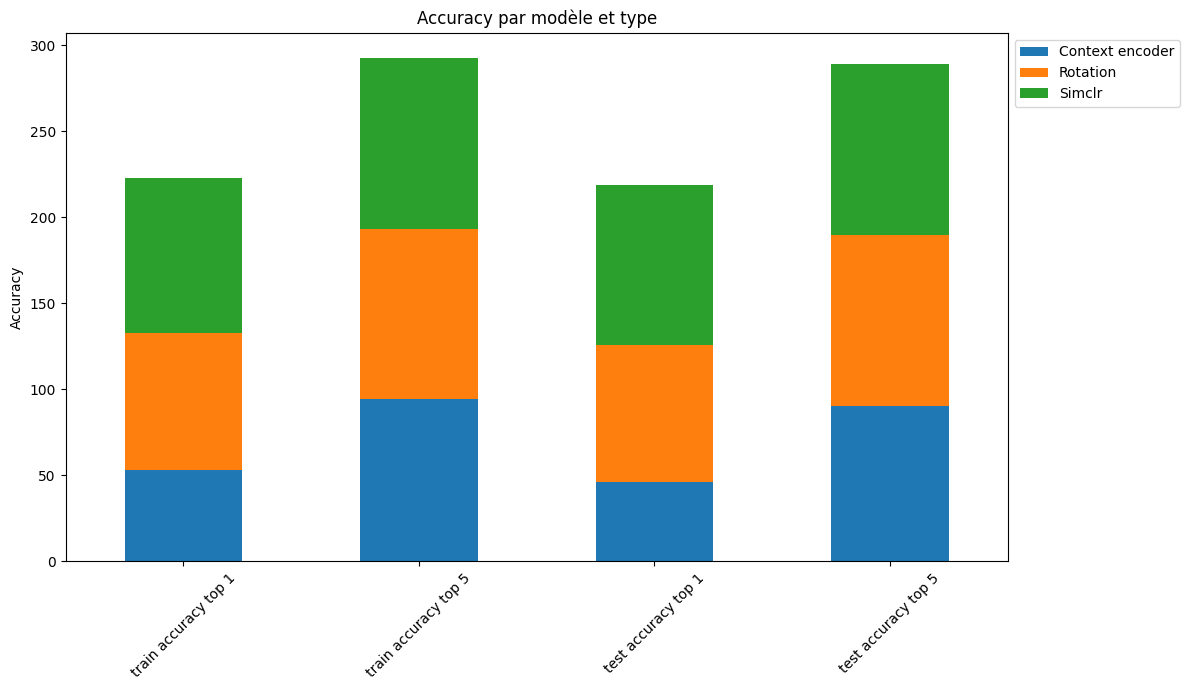

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = df.plot(kind='bar', stacked=True, figsize=(12, 7))

plt.ylabel('Accuracy')
plt.title('Accuracy par modèle et type')
plt.xticks(x, labels, rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


In [25]:
!wget https://pjreddie.com/media/files/imagenet64.tar
!tar -xf imagenet64.tar -C data
!mv data/imagenet64 data/imagenet
!rm imagenet64.tar

--2023-10-30 08:21:26--  https://pjreddie.com/media/files/imagenet64.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10033909760 (9.3G) [application/octet-stream]
Saving to: ‘imagenet64.tar’

imagenet64.tar      100%[===================>]   9.34G  71.0MB/s    in 3m 4s   

2023-10-30 08:24:30 (52.1 MB/s) - ‘imagenet64.tar’ saved [10033909760/10033909760]



In [26]:
!python create_imagenet_subset.py 10
!pip install  warmup_scheduler

Creating a subset of ImageNet with 10 classes
100% 10/10 [00:06<00:00,  1.56it/s]
  Preparing metadata (setup.py) ... done
  Created wheel for warmup_scheduler: filename=warmup_scheduler-0.3-py3-none-any.whl size=2969 sha256=d7b993f26963500e6e263948b92b2f2114e34f9dbab87b59c5756ba584c75bbb
  Stored in directory: /root/.cache/pip/wheels/59/01/9e/d1820991c32916e9808c940f572b462f3e46427f3e76c4d852
Successfully built warmup_scheduler


In [41]:
!python train_self_supervised_task.py -d imagenet10 -t context_encoder -b 64 -e 20 --lr 0.001 --o adam

Starting process on GPU: 0
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[W reducer.cpp:1346] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused p

In [35]:
# model_context_encoder.load_state_dict(torch.load(path + 'model_context_encoder.pth'))

# model_context_encoder.load_state_dict(torch.load(path + 'model_context_encoder.pth'))
# save_path = '/content/cs294-158-ssl/results/imagenet10_context_encoder/model_best.pth.tar'
# torch.save({
#             'model_state_dict': model_context_encoder.state_dict(),
#            }, save_path)
# print(f"Modèle sauvegardé dans {save_path}")
# model_rotation.eval()
# linear_classifier_context_encoder.load_state_dict(torch.load(path + 'linear_classifier_context_encoder.pth'))
# linear_classifier_rotation.eval()

Modèle sauvegardé dans /content/cs294-158-ssl/results/imagenet10_context_encoder/model_best.pth.tar


<All keys matched successfully>

In [42]:
model_context_encoder, linear_classifier_context_encoder, train_loader_context_encoder, test_loader_context_encoder = load_model_and_data('context_encoder',"imagenet10")
train_acc1_context_encoder_, train_acc5_context_encoder_,test_acc1_context_encoder_, test_acc5_context_encoder_ = evaluate_accuracy(model_context_encoder, linear_classifier_context_encoder, train_loader_context_encoder, test_loader_context_encoder)
model1_vals_ = [train_acc1_context_encoder_, train_acc5_context_encoder_,test_acc1_context_encoder_, test_acc5_context_encoder_]

Train Set
Top 1 Accuracy: 27.754435105001743, Top 5 Accuracy: 75.24898847003537

Test Set
Top 1 Accuracy: 22.199999923706056, Top 5 Accuracy: 71.59999981689454



In [ ]:
torch.save(model_context_encoder.state_dict(), path + 'model_context_encoder.pth')
torch.save(linear_classifier_context_encoder.state_dict(), path + 'linear_classifier_context_encoder.pth')

In [45]:
!python train_self_supervised_task.py -d imagenet10 -t rotation -b 64 -e 20 --lr 0.001 --o adam

Starting process on GPU: 0
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[W reducer.cpp:1346] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused p

In [47]:
model_rotation, linear_classifier_rotation, train_loader_rotation, test_loader_rotation = load_model_and_data('rotation',"imagenet10")
train_acc1_rotation_, train_acc5_rotation_,test_acc1_rotation_, test_acc5_rotation_ = evaluate_accuracy(model_rotation, linear_classifier_rotation, train_loader_rotation, test_loader_rotation)
model2_vals_ = [train_acc1_rotation_, train_acc5_rotation_,test_acc1_rotation_, test_acc5_rotation_]

Train Set
Top 1 Accuracy: 51.53283535399023, Top 5 Accuracy: 90.59290383294703

Test Set
Top 1 Accuracy: 55.39999993896485, Top 5 Accuracy: 91.20000006103515



In [ ]:
torch.save(model_rotation.state_dict(), path + 'model_rotation.pth')
torch.save(linear_classifier_rotation.state_dict(), path + 'linear_classifier_rotation.pth')

In [48]:
!python train_self_supervised_task.py -d imagenet10 -t simclr -b 64 -e 20 --lr 0.001 --o adam

Starting process on GPU: 0
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[W reducer.cpp:1346] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused p

In [49]:
model_simclr, linear_classifier_simclr, train_loader_simclr, test_loader_simclr = load_model_and_data('simclr',"imagenet10")
train_acc1_simclr_, train_acc5_simclr_,test_acc1_simclr_, test_acc5_simclr_ =evaluate_accuracy(model_simclr, linear_classifier_simclr, train_loader_simclr, test_loader_simclr)
model3_vals_ = [train_acc1_simclr_, train_acc5_simclr_,test_acc1_simclr_, test_acc5_simclr_]

Train Set
Top 1 Accuracy: 42.32026142959761, Top 5 Accuracy: 88.39869278671212

Test Set
Top 1 Accuracy: 39.799999877929686, Top 5 Accuracy: 89.7999998779297



In [ ]:
torch.save(model_simclr.state_dict(), path + 'model_simclr.pth')
torch.save(linear_classifier_simclr.state_dict(), path + 'linear_classifier_simclr.pth')

In [50]:
labels = ['train accuracy top 1', 'train accuracy top 5','test accuracy top 1', "test accuracy top 5"]
x = range(len(labels))
df_ = pd.DataFrame({
    'Context encoder': model1_vals_,
    'Rotation': model2_vals_,
    'Simclr': model3_vals_
})
df_.index = labels
df_

,Context encoder,Rotation,Simclr
train accuracy top 1,27.754435,51.532835,42.320261
train accuracy top 5,75.248988,90.592904,88.398693
test accuracy top 1,22.200000,55.400000,39.800000
test accuracy top 5,71.600000,91.200000,89.800000


In [57]:

merged_df = pd.concat([df, df_], axis=1, keys=['PreTrained', 'ImageNetTrain'])
merged_df

PreTrained                   ImageNetTrain  \
                     Context encoder Rotation Simclr Context encoder   
train accuracy top 1          53.236   79.502  90.09       27.754435   
train accuracy top 5          94.094   99.096  99.44       75.248988   
test accuracy top 1           45.770   79.910  92.84       22.200000   
test accuracy top 5           90.290   99.120  99.86       71.600000   

                                            
                       Rotation     Simclr  
train accuracy top 1  51.532835  42.320261  
train accuracy top 5  90.592904  88.398693  
test accuracy top 1   55.400000  39.800000  
test accuracy top 5   91.200000  89.800000

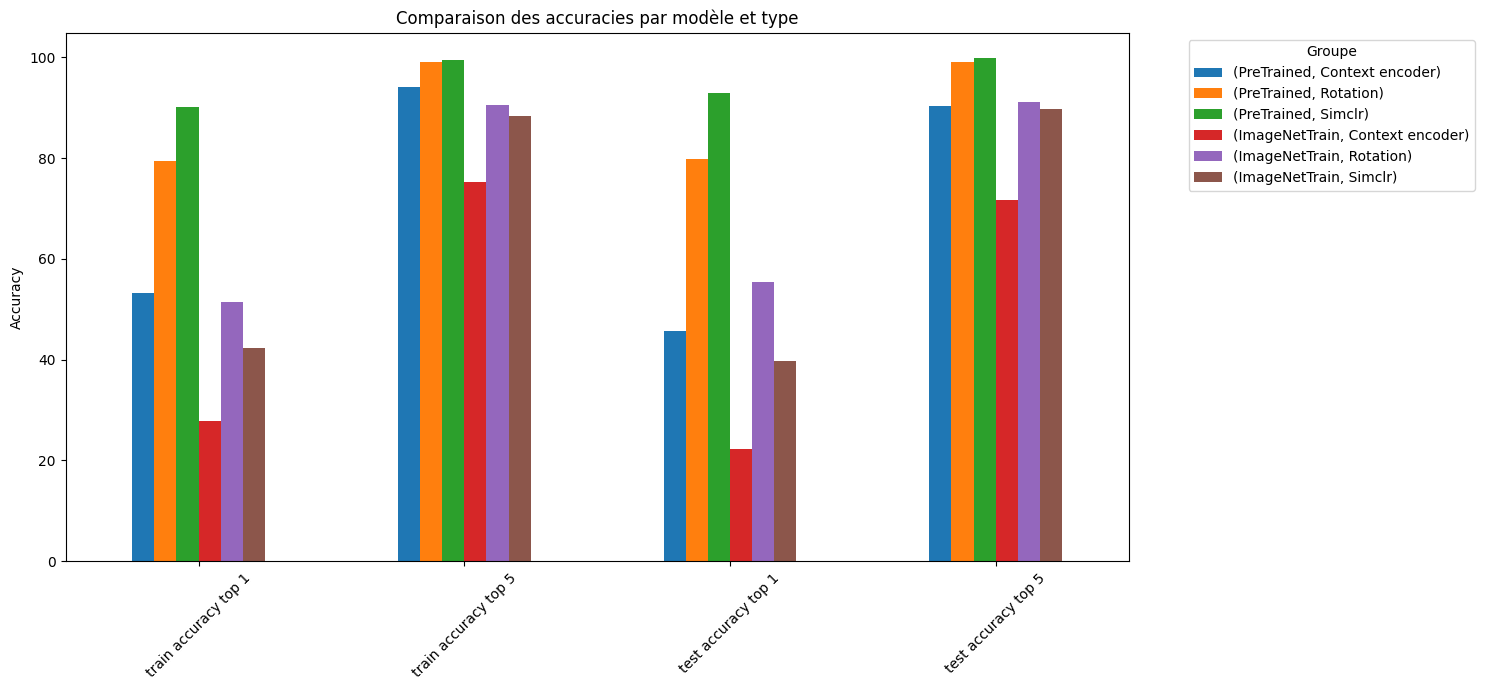

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt


ax = merged_df.plot(kind='bar', figsize=(15, 7))

plt.ylabel('Accuracy')
plt.title('Comparaison des accuracies par modèle et type')
plt.xticks(rotation=45)
plt.legend(title='Groupe', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# df_.to_csv(path+ 'trained_df.csv')

In [ ]:
# model_rotation.load_state_dict(torch.load(path + 'model_rotation.pth'))
# model_rotation.eval()  # Pour le mode d'évaluation

#
# linear_classifier_rotation.load_state_dict(torch.load(path + 'linear_classifier_rotation.pth'))
# linear_classifier_rotation.eval()  # Pour le mode d'évaluation

 # Build la tache contexte from scratch en utilisant l'architecture ResNet

In [59]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset

transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)

def get_patches(image):
    patches = []
    for i in range(3):
        for j in range(3):
            patch = image[:, i*10:(i+1)*10, j*10:(j+1)*10]
            patches.append(patch)
    return patches

def get_context_task(patches):
    reference_idx = np.random.randint(9)
    reference_patch = patches[reference_idx]

    target_idx = np.random.choice([i for i in range(9) if i != reference_idx])
    target_patch = patches[target_idx]

    return reference_patch, reference_idx, target_patch, target_idx

data = []
for images, _ in trainloader:
    image = images[0]
    patches = get_patches(image)
    reference_patch, reference_idx, target_patch, target_idx = get_context_task(patches)
    data.append((reference_patch, reference_idx, target_patch, target_idx))

train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(data, [train_size, val_size, test_size])




100%|██████████| 170498071/170498071 [00:01<00:00, 100203026.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [73]:
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=9):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(6, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
    def construct_classifier(self, block, num_blocks, num_classes=9):
        return nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


In [69]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

# Paramètres
batch_size = 64
learning_rate = 0.001
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model = ResNet101().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)


Epoch 1/20 - Train Loss: 2.2248 - Val Loss: 2.2234 - Val Acc: 12.32%
Epoch 2/20 - Train Loss: 2.1963 - Val Loss: 2.2012 - Val Acc: 13.34%
Epoch 3/20 - Train Loss: 2.1733 - Val Loss: 2.1958 - Val Acc: 14.62%
Epoch 4/20 - Train Loss: 2.1519 - Val Loss: 2.1531 - Val Acc: 16.20%
Epoch 5/20 - Train Loss: 2.1329 - Val Loss: 2.1347 - Val Acc: 17.56%
Epoch 6/20 - Train Loss: 2.1089 - Val Loss: 2.1532 - Val Acc: 16.66%
Epoch 7/20 - Train Loss: 2.0864 - Val Loss: 2.1293 - Val Acc: 19.18%
Epoch 8/20 - Train Loss: 2.0631 - Val Loss: 2.1197 - Val Acc: 18.88%
Epoch 9/20 - Train Loss: 2.0396 - Val Loss: 2.0721 - Val Acc: 21.46%
Epoch 10/20 - Train Loss: 2.0133 - Val Loss: 2.0807 - Val Acc: 21.42%
Epoch 11/20 - Train Loss: 1.9860 - Val Loss: 2.0670 - Val Acc: 22.34%
Epoch 12/20 - Train Loss: 1.9576 - Val Loss: 2.0359 - Val Acc: 23.78%
Epoch 13/20 - Train Loss: 1.9327 - Val Loss: 2.0511 - Val Acc: 23.68%
Epoch 14/20 - Train Loss: 1.9008 - Val Loss: 2.0340 - Val Acc: 24.66%
Epoch 15/20 - Train Loss: 1.8

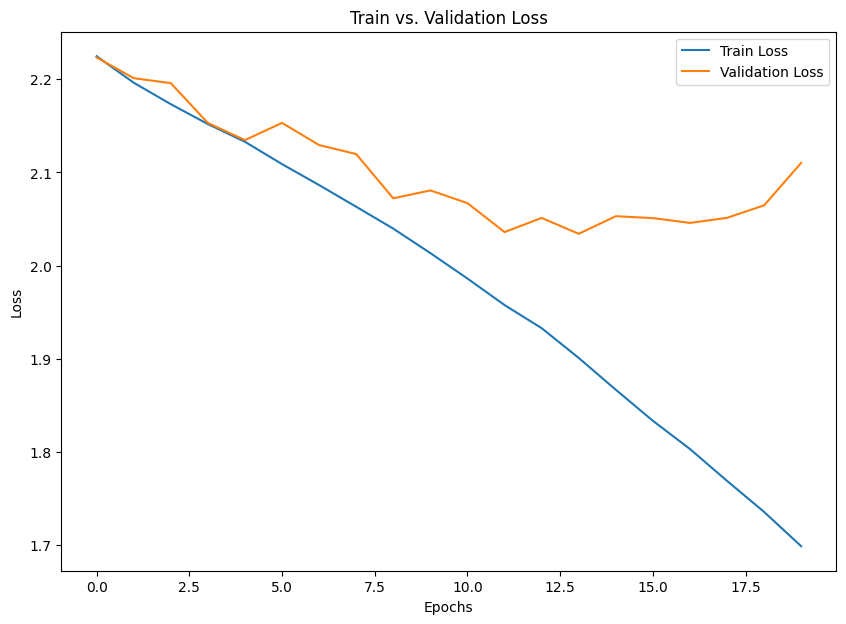

In [70]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0

    for batch_idx, (reference_patch, reference_idx, target_patch, target_idx) in enumerate(train_loader):
        data = torch.cat((reference_patch, target_patch), dim=1)  # Concaténation le long de la dimension des canaux on optien 6 canaux au lieu des 3 habituels
        target = target_idx

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0.0

    with torch.no_grad():
        for reference_patch, reference_idx, target_patch, target_idx in val_loader:
            data = torch.cat((reference_patch, target_patch), dim=1)
            target = target_idx

            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)

            total_loss += loss.item()

            _, predicted = outputs.max(1)
            correct += predicted.eq(target).sum().item()

    accuracy = 100.0 * correct / len(val_loader.dataset)
    return total_loss / len(val_loader), accuracy

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs. Validation Loss")
plt.legend()
plt.show()


In [86]:
import torch
import torch.nn as nn
from deepul_helper.tasks import SimCLR
from deepul_helper.utils import remove_module_state_dict
class JigsawPredictor(nn.Module):
    def __init__(self, base_model, num_classes=9):
        super(JigsawPredictor, self).__init__()
        self.base_model = base_model
        self.classifier = nn.Sequential(
            nn.Linear(base_model.latent_dim * 2 + 1, 512),  # times 2 for concatenated features and +1 for the ID
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, reference_patch, reference_id, target_patch):
        reference_features = self.base_model.encode(reference_patch)
        target_features = self.base_model.encode(target_patch)
        combined_features = torch.cat([reference_features, reference_id.float().unsqueeze(-1), target_features], dim=-1)
        return self.classifier(combined_features)


In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simclr_model = SimCLR(dataset=dataset, n_classes=10)
ckpt_pth = osp.join('results', f'{dataset}_{"simclr"}', 'model_best.pth.tar')
ckpt = torch.load(ckpt_pth, map_location='cpu')
simclr_model.load_state_dict(remove_module_state_dict(ckpt['state_dict']))
jigsaw_predictor = JigsawPredictor(simclr_model).to(device)

optimizer = torch.optim.Adam(jigsaw_predictor.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [91]:
val_losses = []
train_losses = []

num_epochs = 10
for epoch in range(num_epochs):
    jigsaw_predictor.train()
    total_train_loss = 0.0
    for reference_patch, reference_id, target_patch, target_id in train_loader:
        reference_patch, target_patch = reference_patch.to(device), target_patch.to(device)
        reference_id, target_id = reference_id.to(device), target_id.to(device)

        output = jigsaw_predictor(reference_patch, reference_id, target_patch)

        loss = criterion(output, target_id)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    train_losses.append(total_train_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}")

    # Validation loop
    jigsaw_predictor.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for reference_patch, reference_id, target_patch, target_id in val_loader:
            reference_patch, target_patch = reference_patch.to(device), target_patch.to(device)
            reference_id, target_id = reference_id.to(device), target_id.to(device)

            output = jigsaw_predictor(reference_patch, reference_id, target_patch)
            loss = criterion(output, target_id)
            total_val_loss += loss.item()
    val_losses.append(total_val_loss / len(val_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_losses[-1]}")


Epoch 1/10, Training Loss: 2.271183753299713
Epoch 1/10, Validation Loss: 2.0532292052160335
Epoch 2/10, Training Loss: 2.0196388089179993
Epoch 2/10, Validation Loss: 1.9722330690939216
Epoch 3/10, Training Loss: 1.9249142629623412
Epoch 3/10, Validation Loss: 1.916354260867155
Epoch 4/10, Training Loss: 1.8595330386161804
Epoch 4/10, Validation Loss: 1.8127293435833123
Epoch 5/10, Training Loss: 1.8241723525047302
Epoch 5/10, Validation Loss: 1.8060388006741488
Epoch 6/10, Training Loss: 1.8003028226852418
Epoch 6/10, Validation Loss: 1.787970067579535
Epoch 7/10, Training Loss: 1.7821190834999086
Epoch 7/10, Validation Loss: 1.7590721785267698
Epoch 8/10, Training Loss: 1.7582695251464844
Epoch 8/10, Validation Loss: 1.7651539859892447
Epoch 9/10, Training Loss: 1.7366676753044128
Epoch 9/10, Validation Loss: 1.735952157008497
Epoch 10/10, Training Loss: 1.719092816066742
Epoch 10/10, Validation Loss: 1.728237648553486


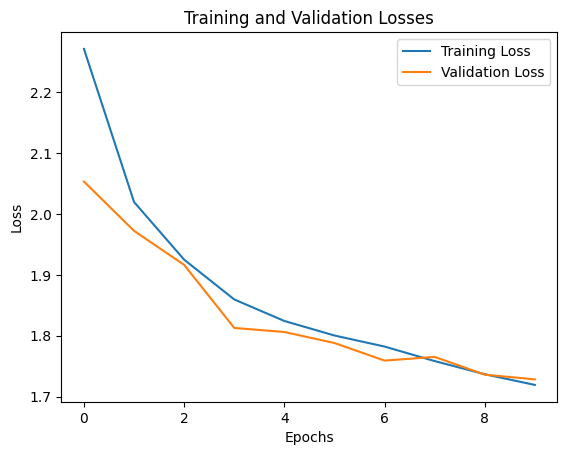

In [92]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


In [97]:
def evaluate_accuracy(model, train_loader, test_loader):
    train_acc1, train_acc5 = evaluate_classifier(model, train_loader)
    test_acc1, test_acc5 = evaluate_classifier(model, test_loader)

    print('Train Set')
    print(f'Top 1 Accuracy: {train_acc1}, Top 5 Accuracy: {train_acc5}\n')
    print('Test Set')
    print(f'Top 1 Accuracy: {test_acc1}, Top 5 Accuracy: {test_acc5}\n')

    return train_acc1, train_acc5, test_acc1, test_acc5
def evaluate_classifier(model, loader):
    correct1, correct5 = 0, 0
    with torch.no_grad():
        model.eval()
        for reference_patch, reference_id, target_patch, target_id in loader:
            reference_patch, target_patch = reference_patch.cuda(), target_patch.cuda()
            reference_id, target_id = reference_id.cuda(), target_id.cuda()

            output = model(reference_patch, reference_id, target_patch)
            acc1, acc5 = accuracy(output, target_id, topk=(1, 9))

            correct1 += acc1.item() * output.shape[0]
            correct5 += acc5.item() * output.shape[0]

    total = len(loader.dataset)
    return correct1 / total, correct5 / total
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


In [98]:
linear_classifier = nn.Linear(jigsaw_predictor.classifier[0].in_features, 9).to(device)
train_acc1_jigsimclr, train_acc5_jigsimclr,test_acc1_jigsimclr, test_acc5_jigsimclr =evaluate_accuracy(jigsaw_predictor, train_loader, test_loader)
model_values = [train_acc1_jigsimclr, train_acc5_jigsimclr,test_acc1_jigsimclr, test_acc5_jigsimclr]

Train Set
Top 1 Accuracy: 39.375, Top 5 Accuracy: 100.0

Test Set
Top 1 Accuracy: 34.74, Top 5 Accuracy: 100.0



In [100]:
labels = ['train accuracy top 1', 'train accuracy top 5','test accuracy top 1', "test accuracy top 5"]
x = range(len(labels))
df_ = pd.DataFrame({
    'Context encoder': model1_vals_,
    'Rotation': model2_vals_,
    'Simclr': model3_vals_,
    'Jigsaw': model_values
})
df_.index = labels
df_

,Context encoder,Rotation,Simclr,Jigsaw
train accuracy top 1,27.754435,51.532835,42.320261,39.375
train accuracy top 5,75.248988,90.592904,88.398693,100.000
test accuracy top 1,22.200000,55.400000,39.800000,34.740
test accuracy top 5,71.600000,91.200000,89.800000,100.000


In [111]:
import os
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.datasets import ImageFolder
IMAGENET10_PATH = '/content/cs294-158-ssl/data/imagenet10'

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

trainset = ImageFolder(root=IMAGENET10_PATH, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)

def get_patches(image):
    patches = []
    for i in range(3):
        for j in range(3):
            patch = image[:, i*10:(i+1)*10, j*10:(j+1)*10]
            patches.append(patch)
    return patches

def get_context_task(patches):
    reference_idx = np.random.randint(9)
    reference_patch = patches[reference_idx]

    target_idx = np.random.choice([i for i in range(9) if i != reference_idx])
    target_patch = patches[target_idx]

    return reference_patch, reference_idx, target_patch, target_idx

data = []
for images, _ in trainloader:
    image = images[0]
    patches = get_patches(image)
    reference_patch, reference_idx, target_patch, target_idx = get_context_task(patches)
    data.append((reference_patch, reference_idx, target_patch, target_idx))

train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(data, [train_size, val_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [112]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simclr_model = SimCLR(dataset=dataset, n_classes=10)
ckpt_pth = osp.join('results', f'{dataset}_{"simclr"}', 'model_best.pth.tar')
ckpt = torch.load(ckpt_pth, map_location='cpu')
simclr_model.load_state_dict(remove_module_state_dict(ckpt['state_dict']))
jigsaw_predictor = JigsawPredictor(simclr_model).to(device)

optimizer = torch.optim.Adam(jigsaw_predictor.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [113]:
val_losses = []
train_losses = []

num_epochs = 10
for epoch in range(num_epochs):
    jigsaw_predictor.train()
    total_train_loss = 0.0
    for reference_patch, reference_id, target_patch, target_id in train_loader:
        reference_patch, target_patch = reference_patch.to(device), target_patch.to(device)
        reference_id, target_id = reference_id.to(device), target_id.to(device)

        output = jigsaw_predictor(reference_patch, reference_id, target_patch)

        loss = criterion(output, target_id)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    train_losses.append(total_train_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}")

    # Validation loop
    jigsaw_predictor.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for reference_patch, reference_id, target_patch, target_id in val_loader:
            reference_patch, target_patch = reference_patch.to(device), target_patch.to(device)
            reference_id, target_id = reference_id.to(device), target_id.to(device)

            output = jigsaw_predictor(reference_patch, reference_id, target_patch)
            loss = criterion(output, target_id)
            total_val_loss += loss.item()
    val_losses.append(total_val_loss / len(val_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_losses[-1]}")


Epoch 1/10, Training Loss: 3.1140556835128876
Epoch 1/10, Validation Loss: 2.189195928119478
Epoch 2/10, Training Loss: 2.187396439249644
Epoch 2/10, Validation Loss: 2.1804083642505465
Epoch 3/10, Training Loss: 2.1824298818668204
Epoch 3/10, Validation Loss: 2.1793284643264044
Epoch 4/10, Training Loss: 2.1791373341383333
Epoch 4/10, Validation Loss: 2.178996790023077
Epoch 5/10, Training Loss: 2.1770993149922995
Epoch 5/10, Validation Loss: 2.1739226636432467
Epoch 6/10, Training Loss: 2.1683878042026907
Epoch 6/10, Validation Loss: 2.1497647081102644
Epoch 7/10, Training Loss: 2.1359175479340697
Epoch 7/10, Validation Loss: 2.1108558859143938
Epoch 8/10, Training Loss: 2.1188955385527923
Epoch 8/10, Validation Loss: 2.1057448500678655
Epoch 9/10, Training Loss: 2.1001854057083587
Epoch 9/10, Validation Loss: 2.0925840650285994
Epoch 10/10, Training Loss: 2.0933595303289905
Epoch 10/10, Validation Loss: 2.0793819086892262


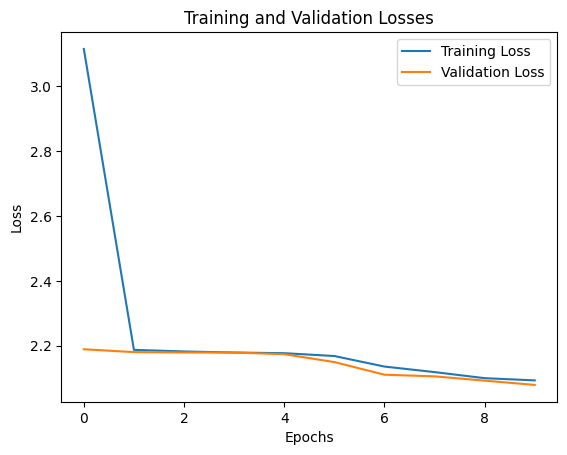

In [114]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


In [115]:
linear_classifier = nn.Linear(jigsaw_predictor.classifier[0].in_features, 9).to(device)
train_acc1_jigsimclr, train_acc5_jigsimclr,test_acc1_jigsimclr, test_acc5_jigsimclr =evaluate_accuracy(jigsaw_predictor, train_loader, test_loader)
model_values = [train_acc1_jigsimclr, train_acc5_jigsimclr,test_acc1_jigsimclr, test_acc5_jigsimclr]

Train Set
Top 1 Accuracy: 18.603127046779193, Top 5 Accuracy: 100.0

Test Set
Top 1 Accuracy: 16.24251497005988, Top 5 Accuracy: 100.0

